In [1]:
try:
    # Comment out if not using colab
    from google.colab import drive
    drive.mount('/content/drive')

    # Specific for luca's computer
    %cd "/content/drive/Othercomputers/Min MacBook Pro/INFO381-GitHub"
    using_colab = True
except:
    print("Not using Google Colab")
    using_colab = False

Mounted at /content/drive
/content/drive/Othercomputers/Min MacBook Pro/INFO381-GitHub


In [2]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-qocg95tm
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-qocg95tm
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.7 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369550 sha256=5f2c71a25463e9b61a291e29627db76d757bcb82ea17ffabce892c182a069739
  Stored in directory: /tmp/pip-ephem-wheel-cache-7xi092xw/wheels/3f/7c/a4/9b490845988bf7a4db33674d52f709f088f64392063872eb9a
Successfully built clip


In [3]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision import models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import clip
from skimage.transform import resize
from PIL import Image


from utils import get_dataloaders, cherry_pick_img_real, cherry_pick_img_ai_generated
from model_definitions import CLIPClassifier

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
train_loader, test_loader = get_dataloaders(batch_size=32, split = 'both')
print(test_loader)

Running in Google Colab


**Load CLIP preprocessing and CNN Transform**

In [5]:
clip_model, preprocess_clip = clip.load("ViT-B/32", device=device)

cnn_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 87.2MiB/s]


**Load dataloaders with both transforms**

In [6]:
cnn_model = models.resnet18(pretrained=False)
cnn_model.fc = nn.Linear(cnn_model.fc.in_features, 2)
cnn_model.load_state_dict(torch.load("models/resnet18_cnn.pth", map_location=device))
cnn_model.eval().to(device)
cnn_model.input_size = (512, 512)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
clip_classifier = CLIPClassifier(clip_model, embed_dim=512, num_classes=2).to(device)
clip_classifier.load_state_dict(torch.load("models/clip_classifier_10epochs.pth", map_location=device))
clip_classifier.eval()
clip_classifier.input_size = (224, 224)

In [8]:
def generate_masks(model, N, s, p1):
    cell_size = np.ceil(np.array(model.input_size) / s).astype(int)
    up_size = ((s + 1) * cell_size).astype(int)

    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')

    masks = np.empty((N, *model.input_size))

    for i in tqdm(range(N), desc='Generating masks'):
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        upsampled = resize(grid[i], up_size, order=1, mode='reflect', anti_aliasing=False)
        masks[i] = upsampled[x:x + model.input_size[0], y:y + model.input_size[1]]

    masks = masks.reshape(N, 1, *model.input_size)
    return masks


In [9]:
def explain(model, inp, masks, N, p1, batch_size=100):
    with torch.no_grad():
        inp_np = inp.cpu().numpy()  # (1, 3, H, W)
        inp_np = inp_np.squeeze(0)  # -> (3, H, W)
        masked = masks * inp_np  # (N, 1, H, W) * (3, H, W) → (N, 3, H, W)

        preds = []
        for i in tqdm(range(0, N, batch_size), desc='Explaining'):
            batch = torch.from_numpy(masked[i:i+batch_size]).to(device).float()
            out = model(batch)
            probs = torch.softmax(out, dim=1).cpu().numpy()
            preds.append(probs)

        preds = np.concatenate(preds, axis=0)
        sal = preds.T @ masks.reshape(N, -1)
        sal = sal.reshape(2, *model.input_size)  # 2 classes
        sal = sal / N / p1
    return sal


In [10]:
def run_rise_get_outputs(image_path, model, transform, class_names, N=2000, s=8, p1=0.5):
    # Load + preprocess image
    img = Image.open(image_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0)

    # Predict
    with torch.no_grad():
        output = model(input_tensor.to(device))
        probs = F.softmax(output, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()
        pred_label = class_names[pred_class]

    # RISE saliency
    masks = generate_masks(model, N, s, p1)
    saliency = explain(model, input_tensor.to(device), masks, N, p1)

    # Also return image as numpy
    img_np = transform(img).permute(1, 2, 0).numpy()

    return {
        "img_np": img_np,
        "saliency": saliency[pred_class],
        "label": pred_label,
        "class_id": pred_class,
        "image_path": image_path
    }

In [31]:
import os
os.makedirs("gui_images/RISE/real/", exist_ok=True)
os.makedirs("gui_images/RISE/ai_generated/", exist_ok=True)

In [32]:
def visualize_side_by_side(original_img_np, cnn_result, clip_result, titles=None, filename="xai_output.png"):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Titles
    if titles is None:
        titles = ["Original Image", "CNN + RISE", "CLIP + RISE"]

    # Original
    axes[0].imshow(original_img_np)
    axes[0].set_title(titles[0], fontsize=13, fontweight="bold")
    axes[0].axis("off")

    # CNN
    axes[1].imshow(cnn_result["img_np"])
    axes[1].imshow(cnn_result["saliency"], cmap='jet', alpha=0.5)
    axes[1].set_title(f"{titles[1]}: {cnn_result['label'].upper()}", fontsize=13)
    axes[1].axis("off")

    # CLIP
    axes[2].imshow(clip_result["img_np"])
    axes[2].imshow(clip_result["saliency"], cmap='jet', alpha=0.5)
    axes[2].set_title(f"{titles[2]}: {clip_result['label'].upper()}", fontsize=13)
    axes[2].axis("off")

    save_path = os.path.join("gui_images/RISE/", filename)
    plt.savefig(save_path, bbox_inches="tight")

    plt.show()
    plt.close()

    print(f"Saved to: {save_path}")


In [12]:
class_names = ['AI GENERATED', 'REAL']

In [15]:
img_path_real_one = cherry_pick_img_real[1]
img_path_real_two = cherry_pick_img_real[2]

img_path_ai_one = cherry_pick_img_ai_generated[1]
img_path_ai_two = cherry_pick_img_ai_generated[2]

**First real image**

In [21]:
cnn_result_one_real = run_rise_get_outputs(
    image_path=img_path_real_one,
    model=cnn_model,
    transform=cnn_transform,
    class_names=class_names
)

clip_result_one_real = run_rise_get_outputs(
    image_path=img_path_real_one,
    model=clip_classifier,
    transform=preprocess_clip,
    class_names=class_names
)

Explaining: 100%|██████████| 20/20 [05:22<00:00, 16.12s/it]


**Second real image**

In [22]:
cnn_result_two_real = run_rise_get_outputs(
    image_path=img_path_real_two,
    model=cnn_model,
    transform=cnn_transform,
    class_names=class_names
)

clip_result_two_real = run_rise_get_outputs(
    image_path=img_path_real_two,
    model=clip_classifier,
    transform=preprocess_clip,
    class_names=class_names
)

Explaining: 100%|██████████| 20/20 [05:29<00:00, 16.45s/it]


**First AI image**

In [23]:
cnn_result_one_ai = run_rise_get_outputs(
    image_path=img_path_ai_one,
    model=cnn_model,
    transform=cnn_transform,
    class_names=class_names
)

clip_result_one_ai = run_rise_get_outputs(
    image_path=img_path_ai_one,
    model=clip_classifier,
    transform=preprocess_clip,
    class_names=class_names
)

Explaining: 100%|██████████| 20/20 [05:35<00:00, 16.76s/it]


**Second AI image**

In [44]:
cnn_result_two_ai = run_rise_get_outputs(
    image_path=img_path_ai_two,
    model=cnn_model,
    transform=cnn_transform,
    class_names=class_names
)

clip_result_two_ai = run_rise_get_outputs(
    image_path=img_path_ai_two,
    model=clip_classifier,
    transform=preprocess_clip,
    class_names=class_names
)

Explaining: 100%|██████████| 20/20 [05:21<00:00, 16.08s/it]


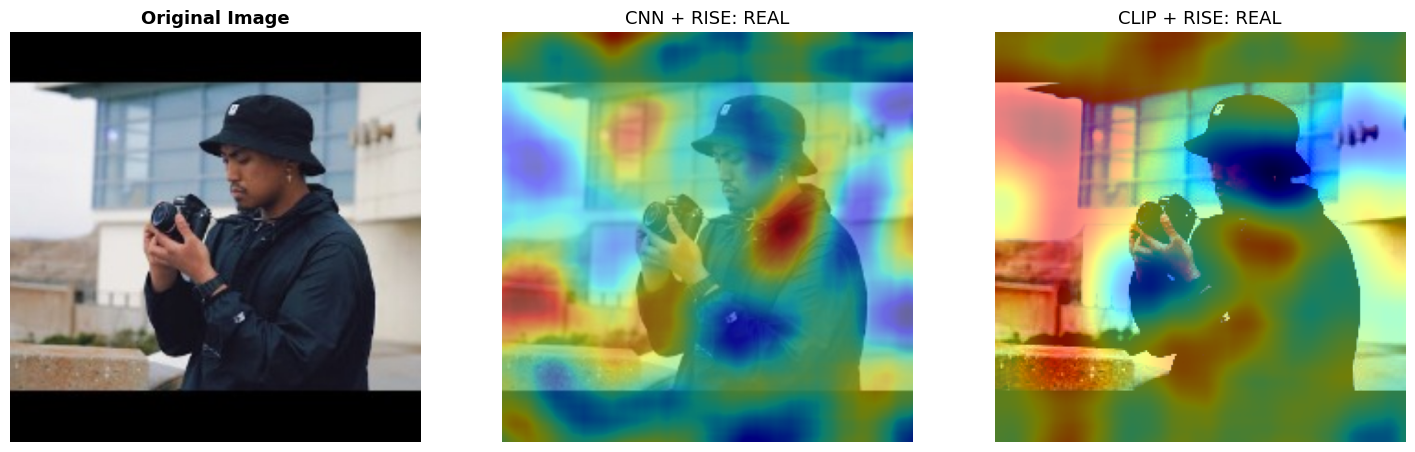

Saved to: gui_images/RISE/real/img1.png
CNN predicts:  REAL (klasse 1)
CLIP predicts REAL (klasse 1)


In [41]:
visualize_side_by_side(
    original_img_np=cnn_result_one_real["img_np"],  # or load again from PIL
    cnn_result=cnn_result_one_real,
    clip_result=clip_result_one_real,
    filename=f"real/img1.png"
)
print(f"CNN predicts:  {cnn_result_one_real['label'].upper()} (klasse {cnn_result_one_real['class_id']})")
print(f"CLIP predicts {clip_result_one_real['label'].upper()} (klasse {clip_result_one_real['class_id']})")

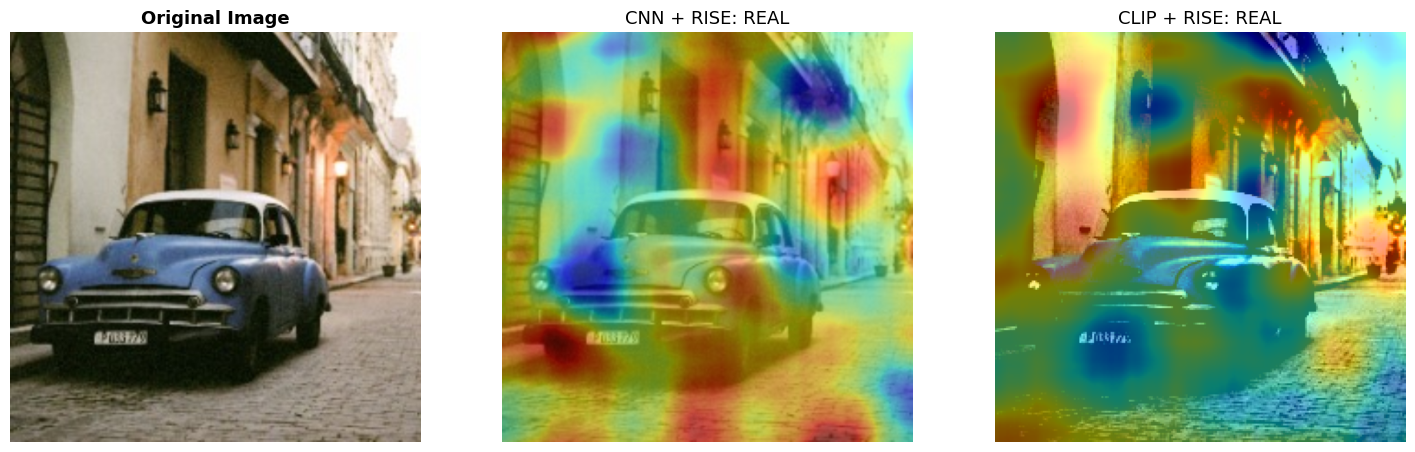

Saved to: gui_images/RISE/real/img2.png
CNN predicts:  REAL (klasse 1)
CLIP predicts REAL (klasse 1)


In [42]:
visualize_side_by_side(
    original_img_np=cnn_result_two_real["img_np"],  # or load again from PIL
    cnn_result=cnn_result_two_real,
    clip_result=clip_result_two_real,
    filename=f"real/img2.png"
)
print(f"CNN predicts:  {cnn_result_two_real['label'].upper()} (klasse {cnn_result_two_real['class_id']})")
print(f"CLIP predicts {clip_result_two_real['label'].upper()} (klasse {clip_result_two_real['class_id']})")

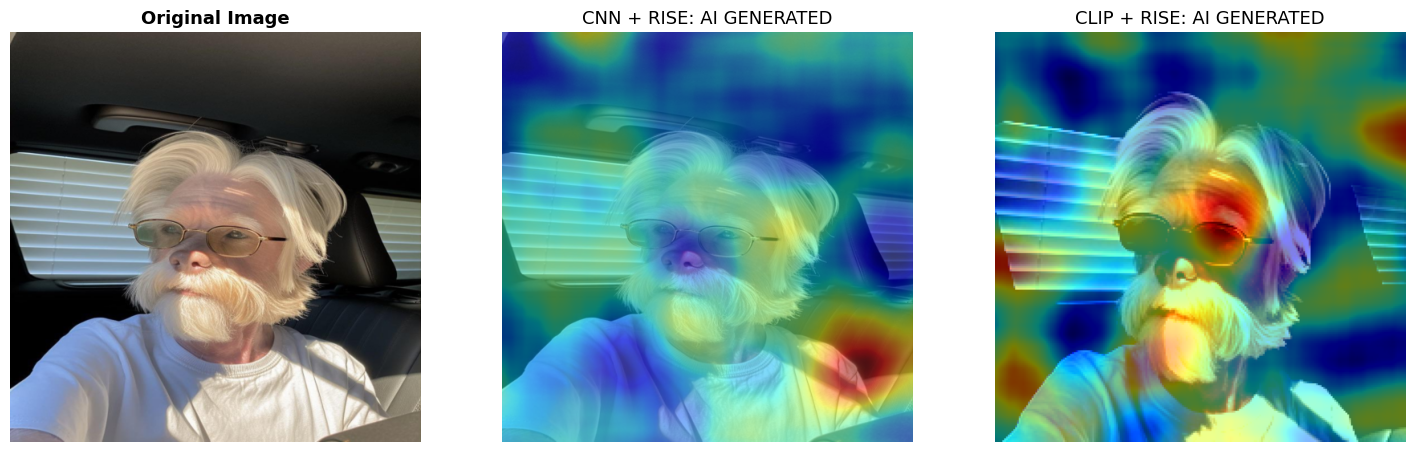

Saved to: gui_images/RISE/ai_generated/img1.png
CNN predicts:  AI GENERATED (klasse 0)
CLIP predicts AI GENERATED (klasse 0)


In [43]:
visualize_side_by_side(
    original_img_np=cnn_result_one_ai["img_np"],  # or load again from PIL
    cnn_result=cnn_result_one_ai,
    clip_result=clip_result_one_ai,
    filename=f"ai_generated/img1.png"
)
print(f"CNN predicts:  {cnn_result_one_ai['label'].upper()} (klasse {cnn_result_one_ai['class_id']})")
print(f"CLIP predicts {clip_result_one_ai['label'].upper()} (klasse {clip_result_one_ai['class_id']})")

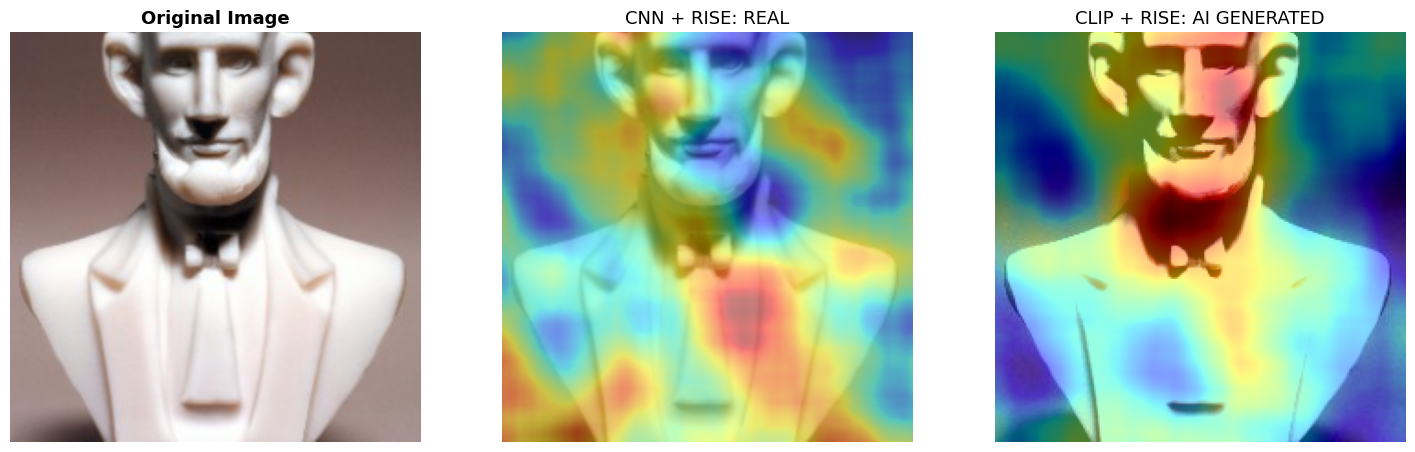

Saved to: gui_images/RISE/ai_generated/img2.png
CNN predicts:  REAL (klasse 1)
CLIP predicts AI GENERATED (klasse 0)


In [47]:
visualize_side_by_side(
    original_img_np=cnn_result_two_ai["img_np"],  # or load again from PIL
    cnn_result=cnn_result_two_ai,
    clip_result=clip_result_two_ai,
    filename=f"ai_generated/img2.png"
)
print(f"CNN predicts:  {cnn_result_two_ai['label'].upper()} (klasse {cnn_result_two_ai['class_id']})")
print(f"CLIP predicts {clip_result_two_ai['label'].upper()} (klasse {clip_result_two_ai['class_id']})")